In [2]:
%reload_ext autoreload
%autoreload 2

import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from scipy.optimize import curve_fit

sys.path.append('D:\projects\diverters\src')

from materials.materials import Duplex

In [3]:
def to_float(str_val):
    try:
        return float(str_val)
    except ValueError:
        return -1
    
def read_props(identifier, path):
    with open(path, 'r') as f:
        vals = None
        for line in f:
            strs = line.split(',')
            if strs[0] == identifier:
                vals = [to_float(val_str) for val_str in strs[1:]]
        return vals

PURE_W_PATH = r"D:\projects\diverters\data\props_csv\pure_w.csv"
K_DOPED_W_RE_3_PATH = r"D:\projects\diverters\data\props_csv\k_doped_w_re_3.csv"

temps = read_props("Temperature", PURE_W_PATH)

pure_w_ult_strength = read_props("Ultimate Strength", PURE_W_PATH)
pure_w_tot_elon = read_props("Total Elongation", PURE_W_PATH)
pure_w_uni_elon = read_props("Uniform Elongation", PURE_W_PATH)
pure_w_therm_cond = read_props("Thermal Conductivity", PURE_W_PATH)

alloy_ult_strength = read_props("Ultimate Strength", K_DOPED_W_RE_3_PATH)
alloy_tot_elon = read_props("Total Elongation", K_DOPED_W_RE_3_PATH)
alloy_uni_elon = read_props("Uniform Elongation", K_DOPED_W_RE_3_PATH)
alloy_therm_cond = read_props("Thermal Conductivity", K_DOPED_W_RE_3_PATH)

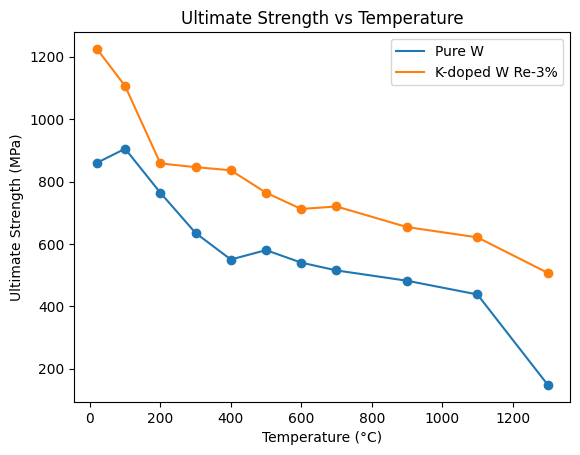

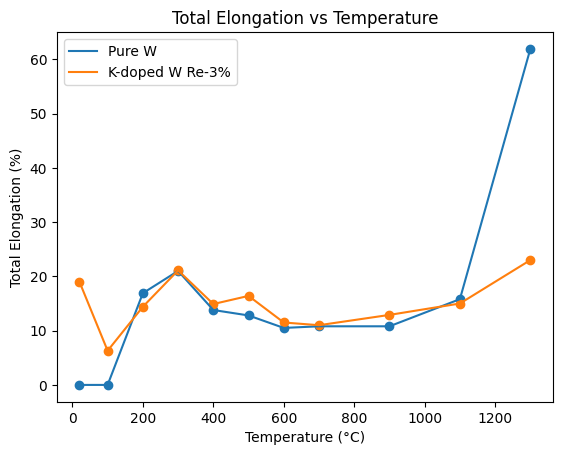

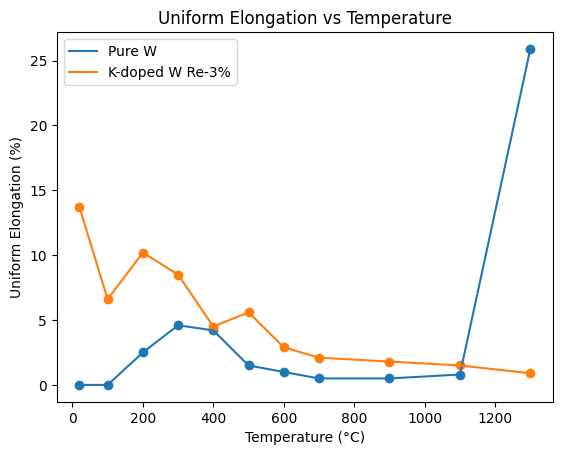

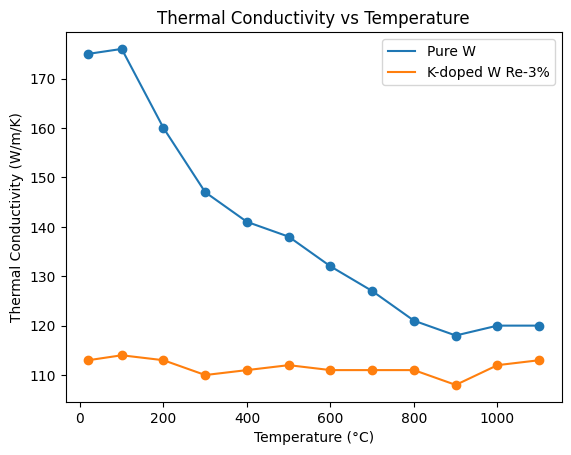

In [4]:
def filter_vals(vals, valid_vals):
    return [val for val, is_valid in zip(vals, valid_vals) if is_valid]

def filter_data(temps, pure_w_props, alloy_props):
    valid_props = [val >= 0 for val in pure_w_props]
    valid_temps = filter_vals(temps, valid_props)
    filtered_pure_w = filter_vals(pure_w_props, valid_props)
    filtered_alloy = filter_vals(alloy_props, valid_props)
    return valid_temps, filtered_pure_w, filtered_alloy

def plot_mat_prop(temps, pure_w_props, alloy_props, prop_str, unit_str):
    valid_temps, filtered_pure_w, filtered_alloy = filter_data(temps, pure_w_props, alloy_props)
    
    ax = plt.subplot()
    ax.plot(valid_temps, filtered_pure_w, label="Pure W")
    ax.scatter(valid_temps, filtered_pure_w)
    ax.plot(valid_temps, filtered_alloy, label="K-doped W Re-3%")
    ax.scatter(valid_temps, filtered_alloy)
    ax.set_title(f"{prop_str} vs Temperature")
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel(f"{prop_str} ({unit_str})")
    ax.legend()
    
    return ax
    
plot_mat_prop(temps, pure_w_ult_strength, alloy_ult_strength, "Ultimate Strength", "MPa")
plt.show()

plot_mat_prop(temps, pure_w_tot_elon, alloy_tot_elon, "Total Elongation", "%")
plt.show()

plot_mat_prop(temps, pure_w_uni_elon, alloy_uni_elon, "Uniform Elongation", "%")
plt.show()

plot_mat_prop(temps, pure_w_therm_cond, alloy_therm_cond, "Thermal Conductivity", "W/m/K")
plt.show()

Pure W:		 a = 0.000057, b = -0.118850, c = 181.145756
K-doped W Re-3%: a = 0.000008, b = -0.010538, c = 114.048757
WL-10:		 a = 0.000034, b = -0.114300, c = 206.800000


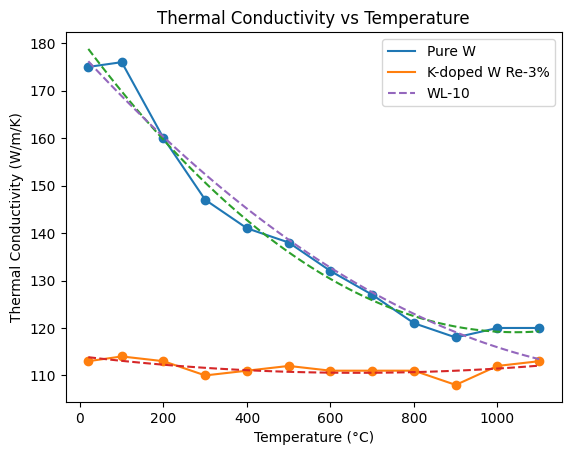

In [5]:
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

therm_cond_temps, pure_w_filtered_therm, alloy_filtered_therm = filter_data(
    temps, 
    pure_w_therm_cond,
    alloy_therm_cond
)

pure_w_coeffs, _ = curve_fit(quadratic_func, therm_cond_temps, pure_w_filtered_therm)
alloy_coeffs, _ = curve_fit(quadratic_func, therm_cond_temps, alloy_filtered_therm)
wl_10_coeffs = (3.372e-5, -0.1143, 206.8)

print("Pure W:\t\t a = {:.6f}, b = {:.6f}, c = {:.6f}".format(*pure_w_coeffs))
print("K-doped W Re-3%: a = {:.6f}, b = {:.6f}, c = {:.6f}".format(*alloy_coeffs))
print("WL-10:\t\t a = {:.6f}, b = {:.6f}, c = {:.6f}".format(*wl_10_coeffs))

x_fit = np.linspace(therm_cond_temps[0], therm_cond_temps[-1], 100)
y_fit_pure_w = [quadratic_func(x, *pure_w_coeffs) for x in x_fit]
y_fit_alloy = [quadratic_func(x, *alloy_coeffs) for x in x_fit]


y_fit_wl_10 = [quadratic_func(x + 273.15, *wl_10_coeffs) for x in x_fit]

ax = plot_mat_prop(temps, pure_w_therm_cond, alloy_therm_cond, "Thermal Conductivity", "W/m/K")
ax.plot(x_fit, y_fit_pure_w, linestyle='dashed')
ax.plot(x_fit, y_fit_alloy, linestyle='dashed')
ax.plot(x_fit, y_fit_wl_10, linestyle='dashed', label="WL-10")
ax.legend()
plt.show()

Power Law Coefficients:	 A = 59.515626, n = 0.412326


C:\Users\PC\AppData\Local\Temp\ipykernel_34860\2967349972.py:2: RuntimeWarning: divide by zero encountered in power
  return a * (x ** n)


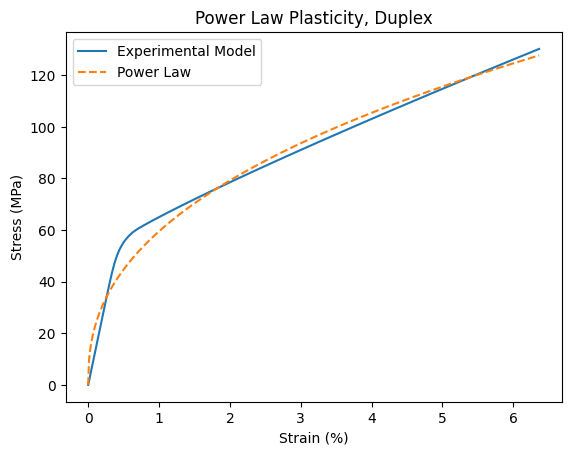

In [6]:
def power_law(x, a, n):
    return a * (x ** n)

duplex = Duplex()
duplex_strain, duplex_stress = duplex.get_stress_strain(870, 100)

duplex_pl_coeffs, _ = curve_fit(power_law, duplex_strain, duplex_stress)
print("Power Law Coefficients:\t A = {:.6f}, n = {:.6f}".format(*duplex_pl_coeffs))

y_fit = [power_law(x, *duplex_pl_coeffs) for x in duplex_strain]

ax = plt.subplot()
ax.plot(duplex_strain, duplex_stress, label="Experimental Model")
ax.plot(duplex_strain, y_fit, linestyle="dashed", label="Power Law")
ax.set_title(f"Power Law Plasticity, Duplex")
ax.set_xlabel("Strain (%)")
ax.set_ylabel(f"Stress (MPa)")
ax.legend()
plt.show()

======== Pure W ========


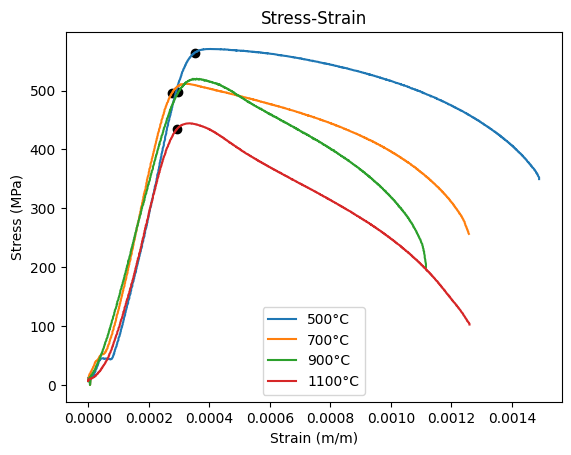

Elastic Moduli:
 500°C: 1.603e+12 Pa
 700°C: 1.784e+12 Pa
 900°C: 1.667e+12 Pa
1100°C: 1.478e+12 Pa

Yield Strengths:
 500°C: 5.643e+08 Pa
 700°C: 4.959e+08 Pa
 900°C: 4.968e+08 Pa
1100°C: 4.347e+08 Pa

Yield Strains:
 500°C: 0.0352%
 700°C: 0.0278%
 900°C: 0.0298%
1100°C: 0.0294%

Ultimate Strengths:
 500°C: 5.702e+08 Pa
 700°C: 5.114e+08 Pa
 900°C: 5.199e+08 Pa
1100°C: 4.44e+08 Pa

Ultimate Strains:
 500°C: 0.0384%
 700°C: 0.0316%
 900°C: 0.0346%
1100°C: 0.0326%

Tangent Moduli:
 500°C: 1.828e+09 Pa
 700°C: 4.058e+09 Pa
 900°C: 4.805e+09 Pa
1100°C: 2.92e+09 Pa


======== K-doped W 3%-Re ========


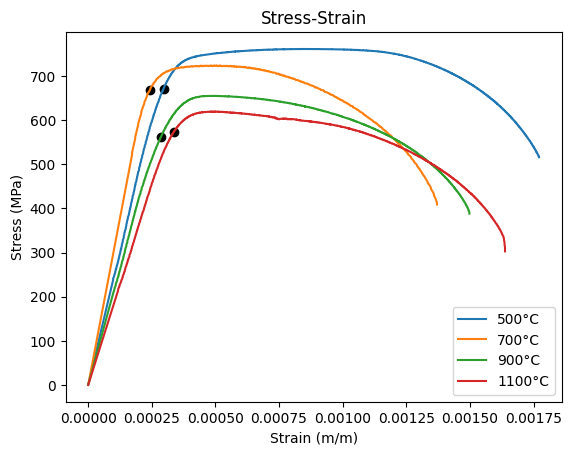

Elastic Moduli:
 500°C: 2.266e+12 Pa
 700°C: 2.758e+12 Pa
 900°C: 1.964e+12 Pa
1100°C: 1.706e+12 Pa

Yield Strengths:
 500°C: 6.708e+08 Pa
 700°C: 6.688e+08 Pa
 900°C: 5.617e+08 Pa
1100°C: 5.733e+08 Pa

Yield Strains:
 500°C: 0.0296%
 700°C: 0.02425%
 900°C: 0.0286%
1100°C: 0.0336%

Ultimate Strengths:
 500°C: 7.584e+08 Pa
 700°C: 7.159e+08 Pa
 900°C: 6.546e+08 Pa
1100°C: 6.179e+08 Pa

Ultimate Strains:
 500°C: 0.064%
 700°C: 0.03305%
 900°C: 0.0448%
1100°C: 0.0444%

Tangent Moduli:
 500°C: 2.545e+09 Pa
 700°C: 5.349e+09 Pa
 900°C: 5.734e+09 Pa
1100°C: 4.13e+09 Pa


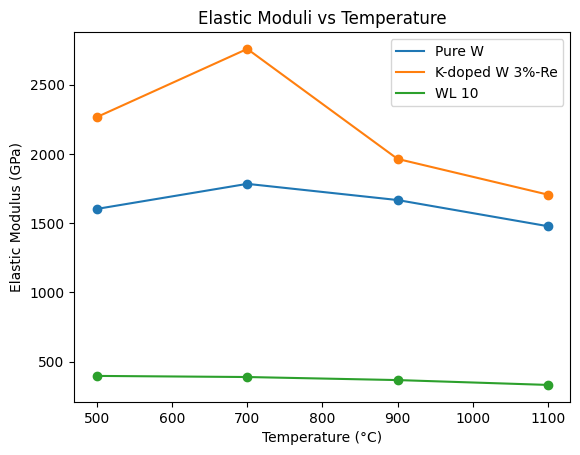

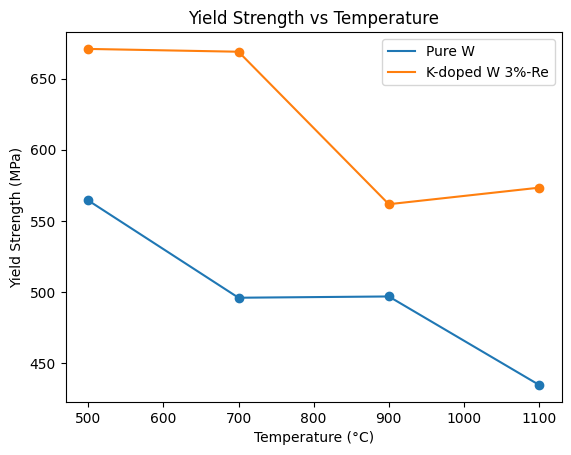

In [10]:
TEMPS = [500, 700, 900, 1100]
ROOT_DIR = r"D:\projects\diverters\data\hasegawa"

def read_stress_strain(path):
    strain = []
    stress = []
    
    with open(path, 'r') as f:
        for line in f:
            vals = line.split(',')
            strain.append(to_float(vals[0]) / 100)
            stress.append(to_float(vals[1]))
            
    return strain, stress

def interp_strain(stress, x, y):
    for i in range(len(y)):
        if y[i] > stress:
            start_i = i
            break
    for i in range(len(y)):
        if y[i] > y[start_i]:
            next_i = i
            break
    
    d_strain = x[next_i] - x[start_i]
    d_stress = y[next_i] - y[start_i]
    rate = d_strain / d_stress
    return x[start_i] + (stress - y[start_i]) * rate

def linear(x, a, b):
    return a * x + b

def lin_coeffs(x, y, lin_x_min, lin_x_max):
    valid = [lin_x_min <= val <= lin_x_max for val in x]
    x_subset = [x[i] for i in range(len(x)) if valid[i]]
    y_subset = [y[i] for i in range(len(y)) if valid[i]]
    return curve_fit(linear, x_subset, y_subset)
    
def yield_stress_strain(x, y, lin_x_min, lin_x_max):
    coeffs, _ = lin_coeffs(x, y, lin_x_min, lin_x_max)
    linear_y = [linear(x_val, *coeffs) for x_val in x]
    
    for strain, stress in zip(x, y):
        diff = strain - interp_strain(stress, x, linear_y)
        if diff > 0.002 / 100:
            return strain, stress
    
    return None

def ult_stress_strain(x, y, start_x):
    for i in range(len(x)):
        if x[i] < start_x:
            continue
        
        if i == len(x) - 3 or y[i] > y[i + 1] and y[i] > y[i + 2] and y[i] > y[i + 3]:
            return x[i], y[i]
        
    
def find_props(mat_str, lin_x_min, lin_x_max):
    def find_temp_props(t, ax):
        x, y = read_stress_strain(os.path.join(ROOT_DIR, f'{mat_str}_{t}.csv'))
        yield_point = yield_stress_strain(x, y, lin_x_min, lin_x_max)
        ult_point = ult_stress_strain(x, y, lin_x_min)
        
        ax.plot(x, y, label=f"{t}°C")
        ax.scatter(yield_point[0], yield_point[1], color='black')
        
        return (yield_point[1] * 10 ** 6 / yield_point[0], 
                yield_point[1] * 10 ** 6, 
                yield_point[0] * 100,
                ult_point[1] * 10 ** 6,
                ult_point[0] * 100)
        
    ax = plt.subplot()
    
    props = []
    for temp in TEMPS:
        props.append(find_temp_props(temp, ax))
    
    ax.set_title(f"Stress-Strain")
    ax.set_xlabel("Strain (m/m)")
    ax.set_ylabel(f"Stress (MPa)")
    ax.legend()
    plt.show()

    print("Elastic Moduli:")
    for i in range(len(TEMPS)):
        print(f"{TEMPS[i]:4}°C: {props[i][0]:.4} Pa")
    
    print("\nYield Strengths:")
    for i in range(len(TEMPS)):
        print(f"{TEMPS[i]:4}°C: {props[i][1]:.4} Pa")
    
    print("\nYield Strains:")
    for i in range(len(TEMPS)):
        print(f"{TEMPS[i]:4}°C: {props[i][2]:.4}%")
        
    print("\nUltimate Strengths:")
    for i in range(len(TEMPS)):
        print(f"{TEMPS[i]:4}°C: {props[i][3]:.4} Pa")
        
    print("\nUltimate Strains:")
    for i in range(len(TEMPS)):
        print(f"{TEMPS[i]:4}°C: {props[i][4]:.4}%")
        
    print("\nTangent Moduli:")
    for i in range(len(TEMPS)):
        tangent_mod = (props[i][3] - props[i][1]) / (props[i][4] - props[i][2])
        print(f"{TEMPS[i]:4}°C: {tangent_mod:.4} Pa")
    
    return (np.array([prop[0] / 1e9 for prop in props]), 
            np.array([prop[1] / 1e6 for prop in props]),
            np.array([prop[2] / 100 for prop in props]),
            np.array([prop[3] / 1e6 for prop in props]),
            np.array([prop[4] / 100 for prop in props]))
        
print("======== Pure W ========")
w_elastic, w_yield_strength, w_yield_strain, w_ult_strength, w_ult_strain = \
    find_props('w', 0.012 / 100, 0.02 / 100)
print("\n\n======== K-doped W 3%-Re ========")
alloy_elastic, alloy_yield_strength, alloy_yield_strain, alloy_ult_strength, alloy_ult_strain = \
    find_props('k_doped_w_3_re', 0.00 / 100, 0.022 / 100)

wl10_emod = [3.98e2, 3.9e2, 3.68e2, 3.33e2]

elastic_ax = plt.subplot()
elastic_ax.plot(TEMPS, w_elastic, label="Pure W")
elastic_ax.scatter(TEMPS, w_elastic)
elastic_ax.plot(TEMPS, alloy_elastic, label="K-doped W 3%-Re")
elastic_ax.scatter(TEMPS, alloy_elastic)
elastic_ax.plot(TEMPS, wl10_emod, label="WL 10")
elastic_ax.scatter(TEMPS, wl10_emod)
elastic_ax.set_title(f"Elastic Moduli vs Temperature")
elastic_ax.set_xlabel("Temperature (°C)")
elastic_ax.set_ylabel(f"Elastic Modulus (GPa)")
elastic_ax.legend()
plt.show()

elastic_ax = plt.subplot()
elastic_ax.plot(TEMPS, w_yield_strength, label="Pure W")
elastic_ax.scatter(TEMPS, w_yield_strength)
elastic_ax.plot(TEMPS, alloy_yield_strength, label="K-doped W 3%-Re")
elastic_ax.scatter(TEMPS, alloy_yield_strength)
elastic_ax.set_title(f"Yield Strength vs Temperature")
elastic_ax.set_xlabel("Temperature (°C)")
elastic_ax.set_ylabel(f"Yield Strength (MPa)")
elastic_ax.legend()
plt.show()